
变分高斯玻色采样的训练
======================================


*前置模块*

[关于玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/boson_sampling/boson_sampling.ipynb)


[关于高斯玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/gaussian_boson_sampling/gaussian_boson_sampling.ipynb)

引言
------

受到机器学习中神经网络成功的启发，许多应用层面的量子算法依赖于变分量子线路的训练，包括：

1. **量子神经网络（Quantum Neural Networks, QNNs）**：一类模仿经典神经网络结构的量子算法，它们使用可变分的量子网络来表示信息，并利用量子力学原理进行信息处理。

2. **量子支持向量机（Quantum Support Vector Machine, QSVM）**：使用变分量子线路定义核函数，用于解决凸优化、分类问题等。

3. **量子近似优化算法（Quantum Approximate Optimization Algorithm, QAOA）**：通过调整量子线路的参数来找到优化问题的近似最优解。

4. **变分量子本征求解器（Variational Quantum Eigensolver, VQE）**：一种用于求解分子能量基态问题的量子算法，通过训练量子线路的参数来近似哈密顿量的最低本征值。

5. **量子机器学习算法（Quantum Machine Learning Algorithms）**：使用可变分的量子算法来加速机器学习任务，例如量子数据编码、量子特征提取等。

6. **量子随机特征（Quantum Random Feature, QRF）**：将量子计算与经典机器学习模型结合的方法，通过量子线路生成高维空间中的随机特征，以提高模型的性能。

在DeepQuantum常规量子线路中，我们也已经展示了若干从简单、中级到困难的变分量子算法的案例👇

[变分量子算法案例](https://deepquantum.turingq.com/category/quantum-variational-algorithm/)

对于光量子模块，[光量子入门介绍](https://github.com/TuringQ/deepquantum/blob/main/docs/photonic_basics.ipynb) 演示了如何搭建含参数的光量子线路，并用Fock后端进行采样测量。

那么，对于独具特色的高斯玻色采样（Gaussian Boson Sampling，简称GBS）任务，我们是否也能完成对于变分线路的构建和训练呢？




理论基础
------

在[关于高斯玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/gaussian_boson_sampling/gaussian_boson_sampling.ipynb)中，我们对高斯玻色采样（GBS）进行了细致的介绍。形如[玻色采样](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/boson_sampling/boson_sampling.ipynb)的概率分布，对于GBS设备，观察到特定输出分布$S$的概率$\Pr(S)$如下：

\begin{equation*}
\Pr(S) = \frac{1}{\mathcal{N}} \frac{|\text{Haf}(A_S)|^2}{s_1!\ldots s_m!},
\end{equation*}

其中，$S=(s_1, s_2, \ldots, s_m)$,  $s_i$是在第$i$个mode探测到的光子数。 
而$\mathcal{N}$ 是一个归一化常数，$A$是一个任意的特征值在 $-1$ 和$1$间的对称矩阵。
矩阵 $A$也可以通过一个常数因子进行重新缩放，相当于定义在目标概率分布中总的平均光子数。

我们希望对这种分布进行**训练**，以执行特定任务。例如，希望再现给定数据集的统计特性，或者优化线路以高概率采样特定模式。以此，任何变分量子算法都有可能在GBS设备上实现。

用数学随机优化模型来表示，给定一个函数$h(S)$和参数$\theta$，我们可以通过采样得到概率分布$P_{\theta}(S)$。而任务的目标则是找到合适的参数$\theta$，来最小化如下期望值：

\begin{equation*}
C (\theta) = \sum_{S} h(S) P_{\theta}(S).
\end{equation*}

此案例将聚焦一个简单的5节点的棒棒糖🍭图。通过变分高斯玻色采样的训练，我们期望在特定的节点观察到尽可能多的光子，而在别的节点观察到尽量少的光子。


完成此变分案例需要以下3步：（i）选用合适的方法编码参数；（ii）调用DeepQuantum模块完成GBS采样模拟；（iii）根据采样结果，选取合适损失函数和优化器完成优化。




问题转化与参数化
-----------------------
我们将会调用DeepQuantum中GBS模块，详情可见[API文档](https://dqapi.turingq.com/deepquantum.photonic.html#deepquantum.photonic.ansatz.GBS_Graph)

首先调用DeepQauntum和相关包：

In [1]:
import deepquantum as dq
import torch

调用networkx包以生成5节点的棒棒糖🍭图，并获得邻接矩阵以对应GBS中特征值在 $-1$ 和$1$间的的对称矩阵$A$。

邻接矩阵A: [[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


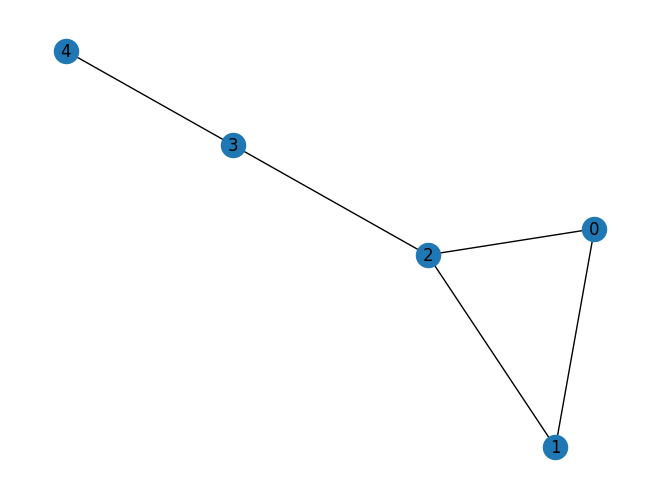

In [2]:
import networkx as nx

graph = nx.lollipop_graph(3, 2)

# 计算邻接矩阵
a = nx.to_numpy_array(graph)
print('邻接矩阵A:', a)

# 可视化图像
nx.draw(graph, with_labels=True)


此时，若无参数化需要，GBS可通过邻接矩阵$A$采样生成概率分布$P(S)$：

In [3]:
gbs = dq.photonic.ansatz.GBS_Graph(adj_mat=a, cutoff=3, mean_photon_num=6)
gbs()

# 高斯玻色采样
sample = gbs.measure(mcmc=True)
print('采样结果为：',sample)

# 计算每个节点理论平均光子数
photon_number = gbs.photon_number_mean_var()[0]
print('每个节点平均光子数为：',photon_number)

Using MCMC method to sample the final states!


chain 5: 100%|█████████████████████████████| 207/207 [00:00<00:00, 20708.41it/s]

采样结果为： {|00000>: 770, |11220>: 1, |11110>: 12, |10100>: 2, |00011>: 7, |10210>: 18, |21100>: 72, |11000>: 44, |11200>: 35, |22200>: 2, |00110>: 8, |01210>: 26, |01100>: 9, |00220>: 1, |11121>: 2, |00121>: 15}
每个节点平均光子数为： tensor([1.3273, 1.3273, 2.0721, 0.9466, 0.3268], dtype=torch.float64)


为了实现变分优化，需要编码参数$\theta$进GBS设备，即参数化矩阵$A$。论文[Training Gaussian Boson Sampling Distributions](https://arxiv.org/abs/2004.04770)中引入了“WAW”的参数化方式，即将对称矩阵$A$转化为

\begin{equation*}
A \rightarrow A_W = W A W,
\end{equation*}

其中$W = \text{diag}(\sqrt{w_1}, \sqrt{w_2}, \ldots, \sqrt{w_m})$ 是对角权重矩阵， $m$是GBS模式数。
这样的构造既可以方便的通过权重$w$实现参数化，又保留了$A$对称的特性。另外，在计算$A_W$的hafnian值时，可通过以下分解分离参数化部分，不会额外增加hafnian的计算难度：

\begin{equation*}
\text{Haf}(A_W) = \text{Haf}(A)\text{det}(W),
\end{equation*}

于是，我们可以方便地编码可训练参数$\theta = (\theta_1, \ldots, \theta_d)$ 进权重 $w_k$。这里，我们选用指数嵌入的形式，

\begin{equation*}
w_k = \exp(-\theta_k),
\end{equation*}

In [4]:
# 生成初始参数
nr_modes = len(a)
params = torch.randn(nr_modes,dtype=torch.float64)
print('初始化参数为: ',params)

# 编码进权重矩阵
weights = torch.exp(-params)
print('指数权重为: ',weights)
w = torch.diag(weights)
print('权重矩阵为: ',w)

# 实现WAW参数化
waw = w @ torch.tensor(a) @ w
print('WAW矩阵为: ',waw)

初始化参数为:  tensor([ 0.0129, -0.2667, -1.5915,  0.6742,  0.5164], dtype=torch.float64)
指数权重为:  tensor([0.9872, 1.3057, 4.9113, 0.5096, 0.5966], dtype=torch.float64)
权重矩阵为:  tensor([[0.9872, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.3057, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.9113, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5096, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5966]], dtype=torch.float64)
WAW矩阵为:  tensor([[0.0000, 1.2889, 4.8483, 0.0000, 0.0000],
        [1.2889, 0.0000, 6.4127, 0.0000, 0.0000],
        [4.8483, 6.4127, 0.0000, 2.5026, 0.0000],
        [0.0000, 0.0000, 2.5026, 0.0000, 0.3040],
        [0.0000, 0.0000, 0.0000, 0.3040, 0.0000]], dtype=torch.float64)


调用DeepQuantum模块完成GBS采样模拟
-----------------------
如前模块所示，调用DeepQuantum实现GBS采样模拟十分便捷。高斯玻色采样（GBS）分布由对称矩阵 $A$ 决定，在经过WAW方法参数化后，我们只需要输入waw矩阵。

总的平均光子数是分布的一个超参数：一般而言，不同的选择可能会导致训练中得到不同的结果。实际上，随着权重被优化，平均光子数在训练过程中可能会发生变化，但不会影响最终相对的概率分布。

最后，GBS设备可以操作具有分辨光子数能力的探测器或阈值探测器，这里我们只使用每个模式上的平均光子数。

In [5]:
#根据精度需求设定cutoff
#设定平均光子数为6（也可设置其它）
gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=3,mean_photon_num=6)
gbs()

# 计算每个节点理论平均光子数
photon_number = gbs.photon_number_mean_var()[0]
print('每个节点平均光子数为：',photon_number)

每个节点平均光子数为： tensor([1.0830e+00, 1.7796e+00, 2.8913e+00, 2.4493e-01, 1.1499e-03],
       dtype=torch.float64)


选取损失函数和优化器，完成优化
-----------------------
根据案例开头的需求，在一个5节点的棒棒糖图中，通过变分高斯玻色采样的训练，我们期望在特定的节点观察到尽可能多的光子，而在别的节点观察到尽量少的光子。不失一般性，我们致力于增加棒棒糖图的“糖果”部分中的光子数，这对应于模式子集``[0, 1, 2]``。

损失函数的构建很多样，先采用最简单的线性损失函数：

In [6]:
#构建期望模式子集
subset = [0, 1, 2]

#构建损失函数
def target(s):
    not_subset = [k for k in range(len(s)) if k not in subset]
    return sum(s[not_subset]) - sum(s[subset])

print('loss值为: ',target(photon_number))

loss值为:  tensor(-5.5078, dtype=torch.float64)


接下来仅需通过优化器，最小化损失函数的值，便可完成对于变分高斯玻色采样设备的训练。

为了方便调用优化器，我们整合上面代码，组合成一个`VGBS`的`class`。

In [7]:
import deepquantum as dq
import networkx as nx
import torch
import torch.nn as nn

graph = nx.lollipop_graph(3, 2)
a = nx.to_numpy_array(graph)
nr_modes = len(a)
subset = [0,1,2]
loss_history = []
result = []

class VGBS(nn.Module):

    def __init__(self):
        super(VGBS,self).__init__()
        self.params = nn.Parameter(torch.randn(nr_modes, dtype=torch.float64), requires_grad=False)
        loss_history.clear()

    def target(self,s):
        not_subset = [k for k in range(len(s)) if k not in subset]
        return sum(s[not_subset]) - sum(s[subset])

    def loss(self,x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x).to(self.params.dtype).reshape(-1)
        weights = torch.exp(-x)
        w = torch.diag(weights)
        waw= w @ torch.tensor(a) @ w

        gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=5,mean_photon_num=6)
        gbs()
        photon_number = gbs.photon_number_mean_var()[0]
        print('每个节点平均光子数为: ',photon_number)
        l = self.target(photon_number)

        loss_history.append(l.item())
        result.clear()
        result.append(photon_number.tolist())

        return l


选取DeepQuantum内建SPSA优化器，设定优化器参数，完成优化。

In [8]:
# 生成刚创建的VGBS模型
model = VGBS()

# 定义优化器参数
spsa_hyperparam = {
    'a': 1,
    'c': 0.01,
    'A': 200,
    'nepoch': 1000,
    'alpha': 0.602,
    'gamma': 0.101
}
optimizer = dq.optimizer.OptimizerSPSA(model.loss, model.params)
optimizer.set_hyperparam(spsa_hyperparam)
param_best = torch.tensor(optimizer.run(100)).float()


每个节点平均光子数为:  tensor([0.0797, 0.1151, 0.1557, 2.8828, 2.7667], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.0795, 0.1119, 0.1526, 2.8860, 2.7700], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.0831, 0.1228, 0.1646, 2.8750, 2.7545], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.0768, 0.1132, 0.1527, 2.8848, 2.7726], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.1362, 0.2041, 0.2594, 2.7919, 2.6084], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.1359, 0.2040, 0.2591, 2.7923, 2.6087], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.1474, 0.2213, 0.2716, 2.7745, 2.5852], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.1257, 0.1883, 0.2477, 2.8081, 2.6301], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.7885, 2.5958, 1.0810, 0.3255, 0.2092], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.8478, 2.6258, 1.0307, 0.2985, 0.1972], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.3449, 2.8291, 0.5930, 0.1277, 0.1053], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.3449, 2.8291, 0.5930, 0.1277, 0.1053], dtype=torch.float64)
每个节点

由优化结果可见，前三个“糖果”节点平均光子数大于“棒子”节点平均光子数，优化成功！



可视化结果
-----------------------
调用`matplotlib`库，绘制优化过程中损失函数随迭代次数下降曲线。
可见在该问题上，虽然使用的是非梯度算法，DeepQuantum自带的`OptimizerSPSA`优化器收敛非常迅速。

Text(0.5, 1.0, 'Loss over time')

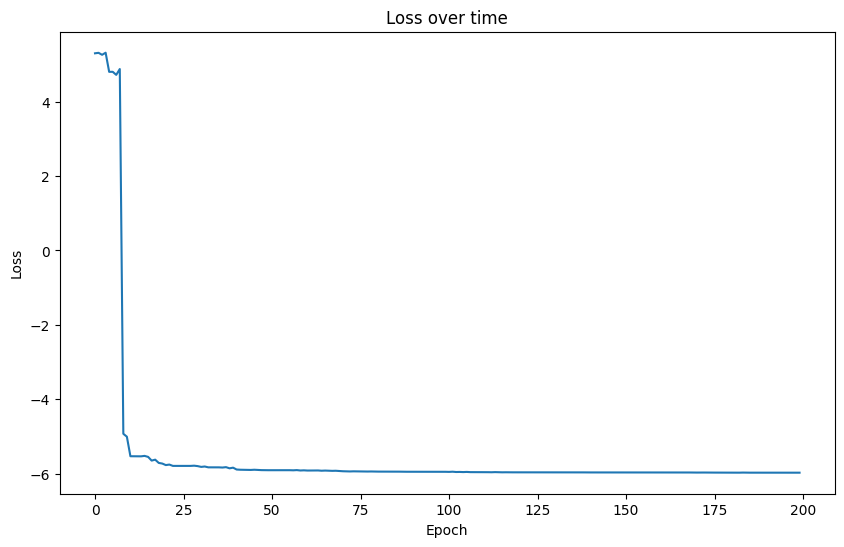

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')

绘制棒棒糖图查看变分优化结果。
其中，每个节点的大小代表平均光子数的多少。
明显可见位于“糖果”处的平均光子数远高于“棒子”，实现了本案例训练的目标。

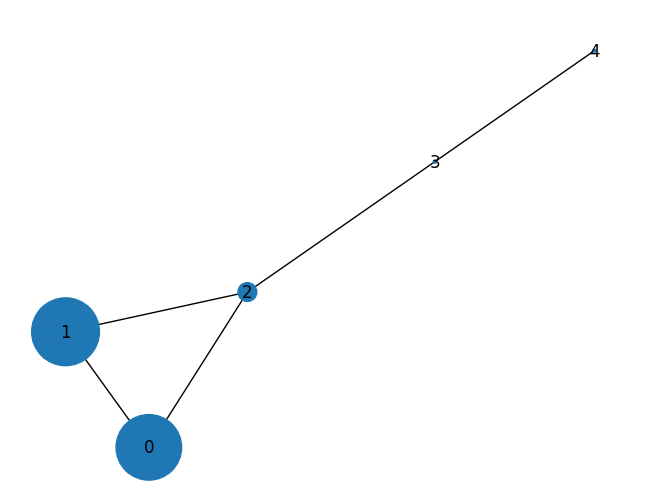

In [10]:
result_scaled = [x * 800 for x in result[0]]
nx.draw(graph, node_size = result_scaled, with_labels=True)

针对损失函数的进一步改进
-----------------------
我们可以观察到，在上个模块中，虽然“糖果”节点处`[0，1，2]`的光子数远高于其它节点，但当前的简单线性损失函数无法很好控制`[0，1，2]`节点的相对光子数。
不失一般性，我们如果额外要求`[0，1，2]`节点的光子数相等，该如何处理？

其实，这项任务本质可以被认为是：训练一个变分高斯采样线路，使其输出的概率分布与目标概率分布相一致。对于概率分布的训练可以通过最小化Kullback-Leibler（KL）散度来执行，这在去掉常数项后可以写成：

\begin{equation*}
KL(\theta) = -\frac{1}{T}\sum_S \log[P_{\theta}(S)].
\end{equation*}


在这种情况下，$ S $ 是概率分布中一个元素，$ P(S) $ 是从GBS分布中抽样时观察到该元素的概率，而 $ T $ 是元素的总数。
据此，我们可以写出新的损失函数`target_kl`:

In [11]:
def target_kl(s):
    return -sum(torch.log(s[subset] / 2))

更新损失函数，再次开始优化：

每个节点平均光子数为:  tensor([1.8368, 0.6379, 2.5418, 0.7347, 0.2488], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.8526, 0.6104, 2.5378, 0.7458, 0.2534], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.7848, 0.7423, 2.5656, 0.6846, 0.2226], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.7688, 0.7349, 2.5487, 0.7055, 0.2421], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.8428, 0.7455, 2.6103, 0.6255, 0.1759], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.7961, 0.7713, 2.5937, 0.6531, 0.1858], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.8297, 0.7758, 2.6078, 0.6175, 0.1693], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.7847, 0.7535, 2.5869, 0.6764, 0.1986], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.0509, 0.8821, 2.6896, 0.3270, 0.0504], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.0685, 0.9028, 2.6729, 0.3063, 0.0495], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.1185, 0.9681, 2.6166, 0.2499, 0.0469], dtype=torch.float64)
每个节点平均光子数为:  tensor([2.1185, 0.9681, 2.6166, 0.2499, 0.0469], dtype=torch.float64)
每个节点

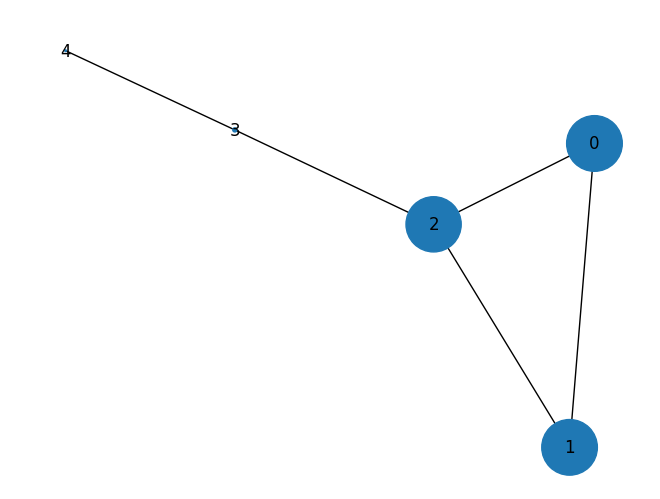

In [13]:
class VGBS(nn.Module):

    def __init__(self):
        super(VGBS,self).__init__()
        self.params = nn.Parameter(torch.randn(nr_modes, dtype=torch.float64), requires_grad=False)
        loss_history.clear()

    # 采用KL散度定义的损失函数
    def target_kl(self,s):
        return -sum(torch.log(s[subset] / 2))

    def loss(self,x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x).to(self.params.dtype).reshape(-1)
        weights = torch.exp(-x)
        w = torch.diag(weights)
        waw= w @ torch.tensor(a) @ w

        gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=5,mean_photon_num=6)
        gbs()
        photon_number = gbs.photon_number_mean_var()[0]
        print('每个节点平均光子数为: ',photon_number)
        l = self.target_kl(photon_number)

        loss_history.append(l.item())
        result.clear()
        result.append(photon_number.tolist())

        return l

model = VGBS()
loss_history = []

# 定义优化器参数
spsa_hyperparam = {
    'a': 1,
    'c': 0.01,
    'A': 200,
    'nepoch': 1000,
    'alpha': 0.602,
    'gamma': 0.101
}
optimizer = dq.optimizer.OptimizerSPSA(model.loss, model.params)
optimizer.set_hyperparam(spsa_hyperparam)
param_best = torch.tensor(optimizer.run(1000)).float()

result_scaled = [x * 800 for x in result[0]]
nx.draw(graph, node_size = result_scaled, with_labels=True)

每个“糖果”节点输出近似2个光子，而其余节点几乎没有输出光子，优化结果非常完美！

# 附录

[1] Leonardo Banchi, Nicolás Quesada, and Juan Miguel Arrazola. Training Gaussian Boson Sampling Distributions. arXiv:2004.04770. 2020.